In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

import nn

In [2]:
with open("data/tinyshakespeare.txt", "r") as f:
    text = f.read()

In [3]:
print(f"Text len: {len(text)}")
VOCAB = set(text)
VOCAB_SIZE = len(VOCAB)
print(f"Vocab size: {VOCAB_SIZE}")

Text len: 1115394
Vocab size: 65


In [4]:
itos = {i: s for i, s in enumerate(VOCAB)}
stoi = {s: i for i, s in itos.items()}

In [5]:
dataset = torch.tensor([stoi[s] for s in text])

In [6]:
x, y = dataset[:-1], dataset[1:]


def train_test_idxs(N, p=0.9):
    idxs = torch.randperm(N)
    split_idx = int(N * p)
    train_idxs = idxs[:split_idx]
    test_idxs = idxs[split_idx:]
    return train_idxs, test_idxs


def make_batch(train_size, n=100):
    return torch.randint(0, train_size, (n,))

In [7]:
(N,) = x.shape
train_idxs, test_idxs = train_test_idxs(N)
train_x, train_y, test_x, test_y = x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

In [8]:
flat_indices = train_x * VOCAB_SIZE + train_y
counts = torch.bincount(flat_indices, minlength=VOCAB_SIZE * VOCAB_SIZE)
counts = counts.view(VOCAB_SIZE, VOCAB_SIZE)

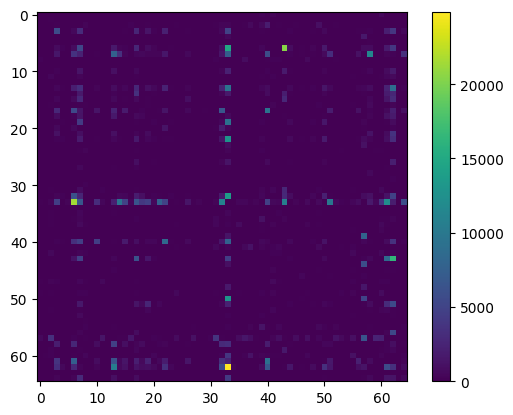

In [9]:
plt.imshow(counts)
plt.colorbar()
plt.show()

In [10]:
probs = counts / counts.sum(1, keepdim=True)

In [11]:
def bgram_model(x):
    return probs[x]

In [12]:
def train(model, iters=10_000, lr=0.01):
    for i in range(iters):
        for p in model.parameters():
            p.grad = None

        batch_idx = make_batch(train_x.shape[0], 1_000)
        batch_x, batch_y = train_x[batch_idx], train_y[batch_idx]
        output = model(batch_x)
        loss = F.cross_entropy(output, batch_y)

        if not i % 100:
            print(f"{i}: {loss}")

        loss.backward()
        for p in model.parameters():
            p.data -= p.grad * lr

In [13]:
N = 1
N_HIDDEN = 100
EMB_DIM = VOCAB_SIZE

simple_model = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, EMB_DIM)
)

print(f"total elements: {sum(p.nelement() for p in simple_model.parameters())}")

for p in simple_model.parameters():
    p.requires_grad = True



total elements: 4225


In [14]:
train(simple_model, 20_000)

0: 4.765132904052734
100: 4.723893642425537
200: 4.685133457183838
300: 4.671329975128174
400: 4.685389518737793
500: 4.682675361633301
600: 4.72192907333374
700: 4.709982872009277
800: 4.695223331451416
900: 4.731446743011475
1000: 4.677750587463379
1100: 4.653419494628906
1200: 4.697393417358398
1300: 4.695194721221924
1400: 4.621432304382324
1500: 4.651374816894531
1600: 4.662385940551758
1700: 4.6442952156066895
1800: 4.640566349029541
1900: 4.581653594970703
2000: 4.567062854766846
2100: 4.6088690757751465
2200: 4.6563920974731445
2300: 4.631380081176758
2400: 4.567288875579834
2500: 4.594020843505859
2600: 4.57794713973999
2700: 4.526576519012451
2800: 4.558552265167236
2900: 4.5433349609375
3000: 4.510764122009277
3100: 4.505856990814209
3200: 4.500183582305908
3300: 4.552049160003662
3400: 4.467811584472656
3500: 4.454833030700684
3600: 4.490151882171631
3700: 4.543191909790039
3800: 4.518191337585449
3900: 4.423428535461426
4000: 4.496529579162598
4100: 4.429016590118408
4200:

In [15]:
from math import log

loss = -log(1/VOCAB_SIZE) 
print(f"uniform prediction loss: {loss}")

pred = simple_model(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"mlp loss: {loss}")

pred = bgram_model(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"bgram loss: {loss}")

uniform prediction loss: 4.174387269895637
mlp loss: 3.7864065170288086
bgram loss: 4.039397716522217


In [16]:
N = 1
N_HIDDEN = 100
EMB_DIM = 2

mlp = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, EMB_DIM), nn.Flatten(), nn.Linear(N * EMB_DIM, N_HIDDEN), nn.Relu(), nn.Linear(N_HIDDEN, VOCAB_SIZE)
)

print(f"total elements: {sum(p.nelement() for p in mlp.parameters())}")

for p in mlp.parameters():
    p.requires_grad = True

total elements: 6995


In [17]:
train(mlp, 20_000)

0: 4.172220706939697
100: 4.089704513549805
200: 4.006311893463135
300: 3.9361276626586914
400: 3.848799467086792
500: 3.7988364696502686
600: 3.7489726543426514
700: 3.6658213138580322
800: 3.568753719329834
900: 3.5995681285858154
1000: 3.5097968578338623
1100: 3.4429595470428467
1200: 3.447239637374878
1300: 3.3994500637054443
1400: 3.3293073177337646
1500: 3.395118474960327
1600: 3.313953161239624
1700: 3.3365397453308105
1800: 3.358894109725952
1900: 3.248979330062866
2000: 3.3490545749664307
2100: 3.3449809551239014
2200: 3.2279961109161377
2300: 3.28379487991333
2400: 3.262423276901245
2500: 3.2356626987457275
2600: 3.277794122695923
2700: 3.2692532539367676
2800: 3.2770540714263916
2900: 3.293670892715454
3000: 3.287551164627075
3100: 3.2871031761169434
3200: 3.25315260887146
3300: 3.185243606567383
3400: 3.2694292068481445
3500: 3.288616180419922
3600: 3.2773995399475098
3700: 3.2490711212158203
3800: 3.225583791732788
3900: 3.260265350341797
4000: 3.237307071685791
4100: 3.23

In [18]:
pred = mlp(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"mlp loss: {loss}")

mlp loss: 2.9468472003936768


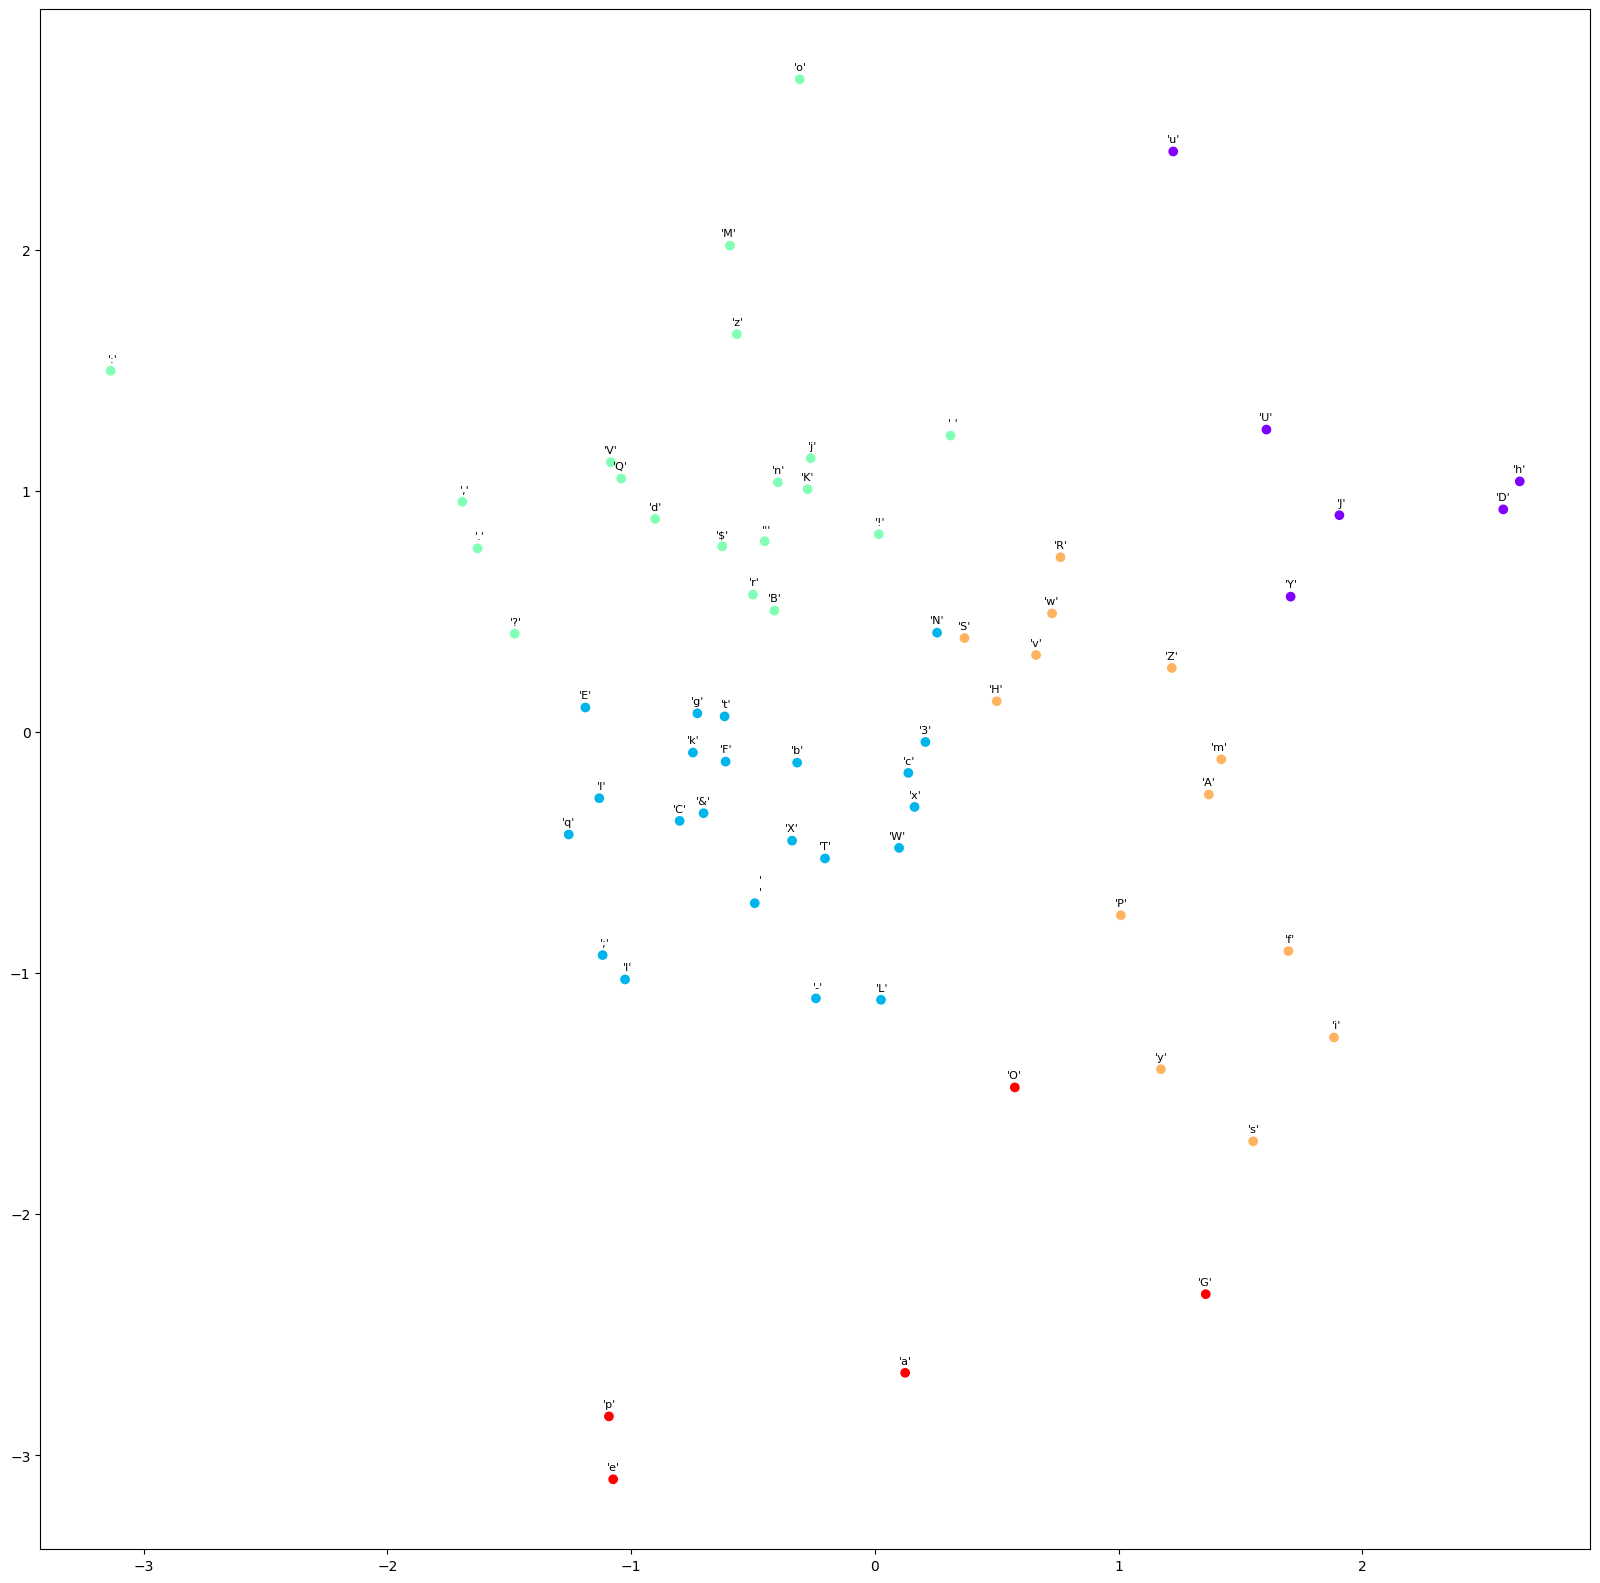

In [19]:
from sklearn.cluster import KMeans
import numpy as np

symbols = mlp.layers[0].parameters()[0].detach()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(symbols)


colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(20, 20))
plt.scatter(symbols[:, 0], symbols[:, 1], c=colors[clusters])
for i, s in itos.items():

    plt.annotate(f"'{s}'",
                 xy=(symbols[i, 0], symbols[i, 1]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=8)